In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read original data

In [52]:
def read_data(id):
    return pd.read_csv('https://drive.google.com/uc?export=download&id='+id_dict[id])

id_dict = {
    'products': '1UjIDfklXUNHDL-97Rjp_fsRL2AYT_2hp',
    'orders': '1zM5DTlLSoQHMiRh_yKpiTeeInJwo3aYW',
    'orderlines': '1qOEtpnats-No2cj_utIxRCuDRtPN255Q',
    'brands': '1JREwR5kHRJNVuzq_f_XQ6W_X1X_C-ueJ',
}

org_products_df = read_data('products')
org_orders_df = read_data('orders')
org_orderlines_df = read_data('orderlines')
org_brands_df = read_data('brands')


In [53]:
products_df = org_products_df.copy()
orders_df = org_orders_df.copy()
orderlines_df = org_orderlines_df.copy()
brands_df = org_brands_df.copy()


## Additional cleaning

In [54]:
orders_df["created_date"] = pd.to_datetime(orders_df["created_date"])
orderlines_df["date"] = pd.to_datetime(orderlines_df["date"])
orderlines_df = orderlines_df.rename(columns={"id_order": "order_id"})

## Add columns for easier analysis

In [55]:
# orderlines:

# add orderline_sum
orderlines_df["orderline_sum"] = orderlines_df["unit_price"] * orderlines_df["product_quantity"]

# add short (sku[:3]) 
orderlines_df["short"] = orderlines_df["sku"].str[:3]

# add price (from products) works only once, that' why the condition
if "price" not in orderlines_df.columns:
    orderlines_df = orderlines_df.merge((products_df[["sku", "price"]]), on="sku")

# add discount amount (price - unit price)
orderlines_df["discount_amt"] = (orderlines_df["price"] - orderlines_df["unit_price"]).round(2)

# add discoount percent (discount amount * 100 / price)
orderlines_df["discount_prc"] = (orderlines_df["discount_amt"] * 100.0 / orderlines_df["price"]).round(1)


# orders:

# add sum of orderline_sum (from orderlines)
if "orderline_total" not in orders_df.columns:
    orders_df = orders_df.merge((orderlines_df.groupby("order_id").agg(orderline_total = ('orderline_sum', 'sum'))), on="order_id")

# products:
# add short (sku[:3])
products_df["short"] = products_df["sku"].str[:3]
# add long brand name
if "long" not in products_df.columns:
    products_df= products_df.merge(brands_df,on='short')

# add min an max price sold from orderlines
if "minprice" not in products_df.columns:
    products_df = products_df.merge((orderlines_df.groupby("sku").agg(minprice=("unit_price","min"), maxprice=("unit_price","max"))), on="sku")




## Add categories

In [56]:
import re

def categorize_product(row):
    """
    Categorize products based on name and description.
    Products with the same 'type' value should ideally belong to the same category.
    """
    # Check SKU-based classification first
    sku = str(row['sku']).upper() if pd.notna(row['sku']) else ''
    if sku.startswith('TPL'):
        return 'Network'
    
    if sku.startswith('PLA'):
        return 'Headsets'

    #if sku.startswith('IKM'):
    #    return 'Audio Equipment'


    type = str(row['type']) if pd.notna(row['type']) else ''
    #types I regognized
    if type=="11935397":
        return 'Memory & Storage'
    
    if type=="1364":
        return 'Memory & Storage'
    
    if type=="12635403":
        return 'Cases & Protection'
    
    if type=="12585395":
        return 'Cables & Adapters'
    
    if type=="5384":
        return 'Headsets'
    
    if type=="1433":
        return 'Memory & Storage'
    
    if type=="12175397":
        return 'Servers & NAS'
    
    
    # Clean name by removing condition-related prefixes
    name_value = str(row['name'])
    name_clean = re.sub(r'^(Open -|Like new -)\s*', '', name_value, flags=re.IGNORECASE)


        # Clean description by removing refurbishment keywords
    desc_value = row.get('desc', '')
    if pd.isna(desc_value):
        desc_value = ''
    desc_clean = re.sub(r'\b(Refurbished|Reconditioned)\b', '', str(desc_value), flags=re.IGNORECASE)
    
    # Combine cleaned name and description for analysis (convert to lowercase)
    text = name_clean.lower() + ' ' + desc_clean.lower()
    price = float(row['price']) if pd.notna(row['price']) else 0
    
    # Normalize description for prefix-based rules
    desc_text = desc_clean.strip().lower()

    if 'switch' in text and 'port' in text:
        return 'Network'

    
    # Define category keywords and patterns
    # Wearables: Apple Watch devices and bundles marked by leading description
    if desc_text.startswith('apple watch') or re.match(r'^\d{1,3}mm apple watch', desc_text):
        return 'Wearables'
    
    # Wearables: Bluetooth smart watches
    if 'bluetooth smart watch' in text or 'bluetooth smartwatch' in text:
        return 'Wearables'
    

    # Stands and mounts for phones/tablets
    if any(word in text for word in ['stand', 'support', 'mount', 'dock', 'docking station', 'holder',
                                        'base', 'tripod']):
        return 'Stands & Mounts'
    
    # AirPods: Apple wireless earbuds
    if any(word in text for word in ['headphone', 'headset', 'earphone', 'airpods', 'airpod']):
        return 'Headsets'
    
    if any(word in text for word in [ 'wacom', 'bamboo', 'graphics tablet', 'intuos']):
        return 'Graphics & Drawing Tools'
    
    # Memory devices called out by size-first SSD descriptions
    if (re.match(r'^\d+\s*gb ssd', desc_text) or 
        re.match(r'^\d+(?:\.\d+)?\s*tb ssd', desc_text) or 
        desc_text.startswith('ssd hard drive')  or
        desc_text.startswith('ssd expansion') or 
        re.match(r'^expansion of \d+(?:\.\d+)?\s*[tg]b ssd', desc_text) ):
        return 'Memory & Storage'
    
    # Services (explicit service products only; ignore generic warranty mentions like "xx years warranty")
    if any(word in text for word in ['applecare', 'apple care', 'protection plan', 
                                      'service plan', 'extended warranty', 'care pack', 'repair service']):
        return 'Services'
    
    # Software and licenses
    if any(word in text for word in ['license', 'software', 'pack license']):
        return 'Software & Licenses'
    
    # Extension/Expansion kits are memory (check before generic 'case' rule)
    if any(word in text for word in ['extension kit', 'expansion kit']):
        return 'Memory & Storage'
    
    # Cases and accessories first (more specific, to avoid misclassification)
    if any(word in text for word in ['case', 'cover', 'sleeve', 'housing', 'shell', 'protector']):
        return 'Cases & Protection'
    
    # Battery cases usually have higher price but still cases
    if any(word in text for word in ['battery case', 'juice pack']):
        return 'Cases & Protection'
    
    # Dedicated memory kits (place before NAS/servers to avoid misclassifying RAM upgrades)
    if any(word in text for word in ['memory for', 'ram for', 'memory upgrade for']):
        return 'Memory & Storage'

    # Server / NAS devices
    if any(word in text for word in ['nas', 'rackstation', 'synology', 'qnap', 'server']):
        return 'Servers & NAS'

    # Computers (laptops/desktops/all-in-one) before memory so they don't fall into RAM keywords
    if any(word in text for word in ['macbook pro', 'macbook air', 'macbook', 'imac', 'mac mini', 'macmini', 'mac pro', 'laptop', 'notebook', 'desktop', 'tower']) and price > 400:
        return 'Computers'

    # Now check for actual phones (should be expensive, >200)
    if any(word in text for word in ['iphone', 'phone', 'smartphone']) and price > 300:
        return 'Phones'
    
    # Tablets (should be expensive, >150)
    if any(word in text for word in ['ipad', 'tablet']) and price > 250:
        return 'Tablets'
    
    if any(word in text for word in ['helicopter', 'toy',  'drone']):
        return 'Toys & Entertainment'

    
    if any(word in text for word in ['keyboard', 'keypad', 'key pad']):
        return 'Keyboards & Input Devices'
    
    if any(word in text for word in ['mouse', 'trackpad', 'magic trackpad']):
        return 'Keyboards & Input Devices'
    
    if any(word in text for word in ['jetdrive', 'jumpdrive', 'memory for']):
        return 'Memory & Storage'

    if any(word in text for word in ['ram', 'dimm', 'sodimm', 'so-dimm', 'ddr', 'ecc', 'pc3', 'pc2', 'pc4', 'memory kit', 'memory module']):
        return 'Memory & Storage'

    if any(word in text for word in ['adapter', 'connector']):
        return 'Cables & Adapters'

    if any(word in text for word in ['pendrive', 'flash drive' 'hard drive', 'hdd', 'ssd', 'storage', 'barracuda', 'external hard', 'harddisk', 'nvme', 'm.2', 'solid state']):
        return 'Memory & Storage'
    
    if any(word in text for word in ['cable', 'adapter', 'connector', 'usb', 'hdmi', 'vga', 'dvi', 
                                        'thunderbolt', 'firewire', 'displayport', 'mini display',
                                        'ethernet adapter', 'dock connector']):
        return 'Cables & Adapters'
    
    if any(word in text for word in ['charger', 'magsafe', 'power', 'battery', 'charging']):
        return 'Power & Charging'
    
    if any(word in text for word in [ 'audio', 'speaker', 'microphone',
                                        'music receiver', 'mic']):
        return 'Audio Equipment'
    
    if any(word in text for word in ['monitor', 'display', 'screen']) and price > 100:
        return 'Monitors & Displays'
    
    if any(word in text for word in ['lock', 'security', 'theft', 'clicksafe', 'antitheft']):
        return 'Security & Locks'
    
    if any(word in text for word in ['camera', 'lens', 'photo', 'video']):
        return 'Camera & Photo'
    
    if any(word in text for word in ['cleaner', 'cleaning', 'maintenance']):
        return 'Cleaning & Maintenance'
    
    if any(word in text for word in ['scale', 'wireless scale']):
        return 'Health & Fitness'
    
    if any(word in text for word in ['guitar', 'dj', 'mixer', 'irig', 'music production']):
        return 'Audio Equipment'
    
    
    if any(word in text for word in ['apple tv', 'media player']):
        return 'Media Players'
    
    # Catch remaining phone/tablet accessories (cheap items with phone/tablet keywords)
    if any(word in text for word in ['iphone', 'ipad', 'ipod', 'phone', 'tablet']):
        return 'Phone & Tablet Accessories'
    

    return 'Accessories'


def check_if_refurbished(row):
    """
    Check if a product is refurbished based on name and description.
    Returns 'Refurbished' or 'New'.
    """
    text = str(row['name']).lower() + ' ' + str(row['desc']).lower()
    
    # Keywords indicating refurbished items
    refurbished_keywords = [
        'refurbished', 'refurb', 'renewed', 'reconditioned', 
        'used', 'open box', 'oem', 'unboxed', 'pre-owned',
        'second hand', 'secondhand', 'reacondicionado', 'open -', 'like new -'

    ]
    
    if any(keyword in text for keyword in refurbished_keywords):
        return 'Refurbished'
    else:
        return 'New'


# Apply the categorization functions
products_df['category'] = products_df.apply(categorize_product, axis=1)
products_df['condition'] = products_df.apply(check_if_refurbished, axis=1)

# Display the results
print("Category distribution:")
print(products_df['category'].value_counts())
print("\n" + "="*80 + "\n")

print("Condition distribution:")
print(products_df['condition'].value_counts())
print("\n" + "="*80 + "\n")

# Show sample products from each category with prices
print("Sample products by category:")
for category in sorted(products_df['category'].unique()):
    print(f"\n{category}:")
    sample = products_df[products_df['category'] == category][['sku', 'name', 'price', 'condition', 'type']].head(3)
    for idx, row in sample.iterrows():
        print(f"  - {row['sku']}: {row['name']} (${row['price']}, {row['condition']}, type: {row['type']})")

# Show price statistics by category
print("\n" + "="*80 + "\n")
print("Price statistics by category:")
price_stats = products_df.groupby('category')['price'].agg(['count', 'mean', 'min', 'max']).round(2)
print(price_stats.sort_values('mean', ascending=False))

# Show refurbished items
print("\n" + "="*80 + "\n")
print("Sample refurbished items:")
refurbished = products_df[products_df['condition'] == 'Refurbished'][['sku', 'name', 'price', 'category']].head(10)
for idx, row in refurbished.iterrows():
    print(f"  - {row['sku']}: {row['name']} (${row['price']}, {row['category']})")

# Check if products with same 'type' have the same category
print("\n" + "="*80 + "\n")
print("Checking consistency: Products with same 'type' value:")
type_category_map = products_df.groupby('type')['category'].unique()
inconsistent_types = type_category_map[type_category_map.apply(len) > 1]

if len(inconsistent_types) > 0:
    print(f"\nFound {len(inconsistent_types)} type values with multiple categories:")
    for type_val, categories in inconsistent_types.head(10).items():
        print(f"\nType {type_val}:")
        for cat in categories:
            count = len(products_df[(products_df['type'] == type_val) & (products_df['category'] == cat)])
            print(f"  - {cat}: {count} products")
else:    print("All products with the same 'type' value belong to the same category!")

# Show breakdown by category and conditionprint(pd.crosstab(products_df['category'], products_df['condition']))

print("\n" + "="*80 + "\n")
print("Products by category and condition:")

Category distribution:
category
Cases & Protection            1213
Memory & Storage               903
Cables & Adapters              663
Stands & Mounts                368
Servers & NAS                  283
Accessories                    213
Phone & Tablet Accessories     202
Phones                         182
Power & Charging               159
Headsets                       139
Audio Equipment                107
Graphics & Drawing Tools        97
Tablets                         97
Computers                       68
Keyboards & Input Devices       64
Wearables                       61
Monitors & Displays             57
Network                         44
Camera & Photo                  44
Security & Locks                28
Services                        28
Toys & Entertainment            27
Health & Fitness                13
Media Players                    9
Software & Licenses              8
Cleaning & Maintenance           2
Name: count, dtype: int64


Condition distribution:
condit

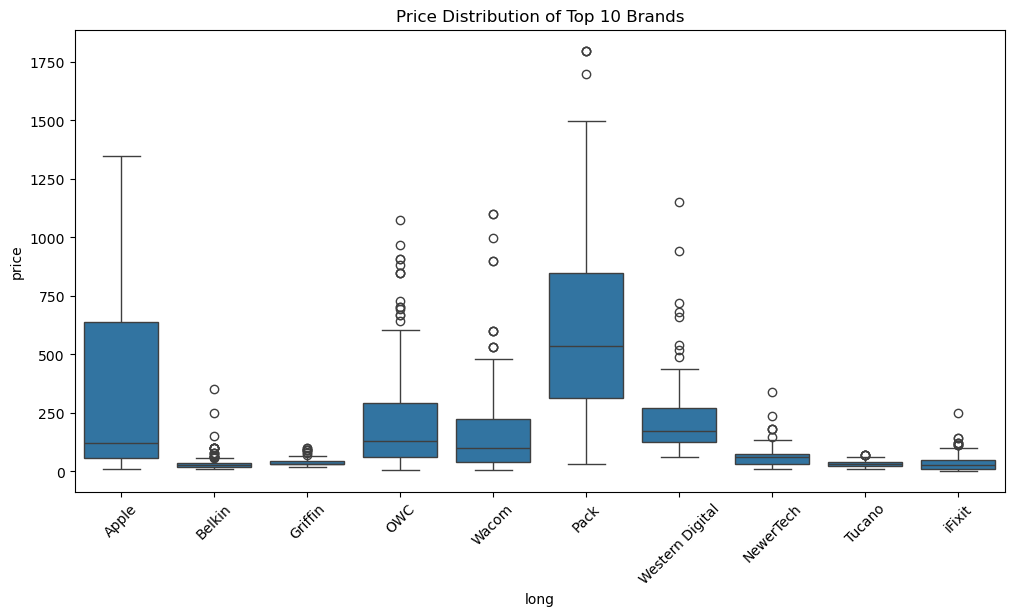

In [57]:
top_brands = products_df['long'].value_counts().head(10).index
subset = products_df[products_df['long'].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=subset, x='long', y='price')
plt.xticks(rotation=45)
plt.title('Price Distribution of Top 10 Brands')
plt.show()

### Business question: What is the distribution of product prices across different categories?

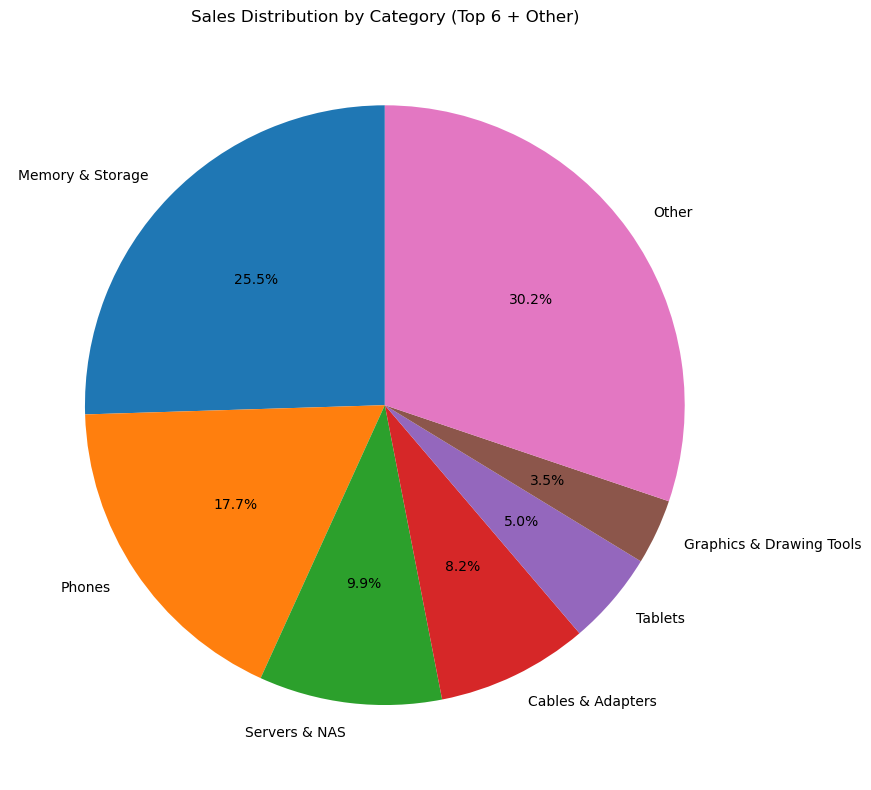

In [66]:
#add cat to orderlines
if "category" in orderlines_df.columns:
    orderlines_df = orderlines_df.drop('category', axis=1)

orderlines_df = orderlines_df.merge((products_df[['sku','category']]), on="sku")
category_totals = orderlines_df.groupby('category').agg(total=('orderline_sum', 'sum'))

# Keep top 6 categories, group the rest as 'Other'
top_6 = category_totals.nlargest(6, 'total')
other_total = category_totals.loc[~category_totals.index.isin(top_6.index), 'total'].sum()

if other_total > 0:
    top_6 = pd.concat([top_6, pd.DataFrame({'total': [other_total]}, index=['Other'])])

# Create pie chart
plt.figure(figsize=(12, 8))
plt.pie(top_6['total'], labels=top_6.index, autopct='%1.1f%%', startangle=90)
plt.title('Sales Distribution by Category (Top 6 + Other)')
plt.tight_layout()
plt.show()

C:\Users\Marcus\AppData\Local\Temp\ipykernel_19888\1021091345.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_revenue.values, y=brand_revenue.index, ax=axes[0], palette='viridis')
C:\Users\Marcus\AppData\Local\Temp\ipykernel_19888\1021091345.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_revenue.values, y=category_revenue.index, ax=axes[1], palette='rocket')


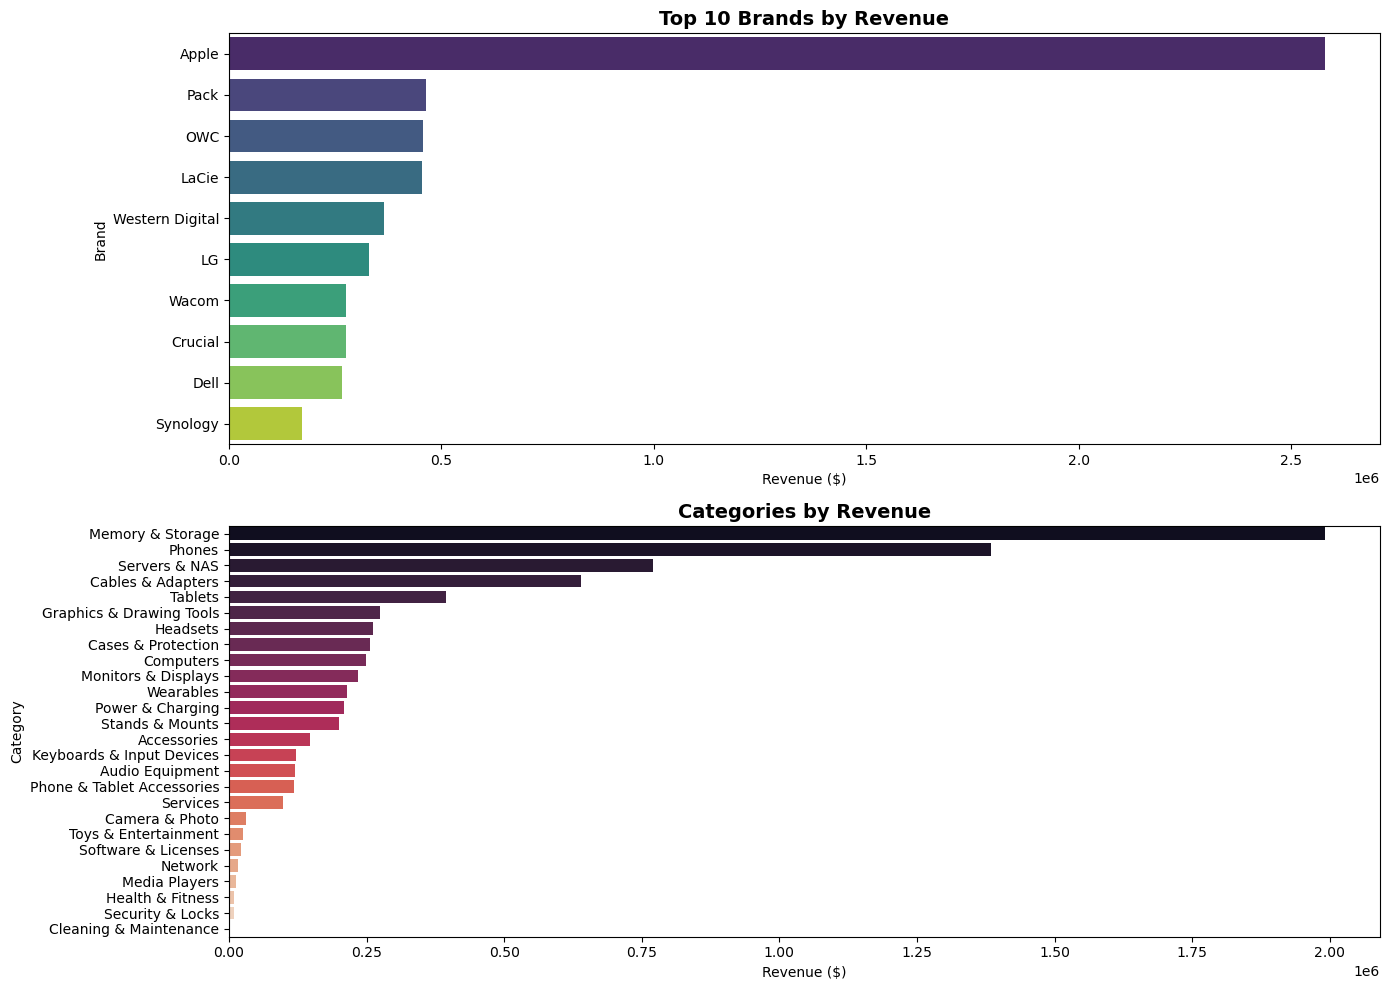

In [74]:
# Revenue distribution by brands and categories
# First, add brand information to orderlines
orderlines_with_brand = orderlines_df.merge(products_df[['sku', 'long']], on='sku')

# Calculate revenue by category
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Top 10 brands by revenue
brand_revenue = orderlines_with_brand.groupby('long')['orderline_sum'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=brand_revenue.values, y=brand_revenue.index, ax=axes[0], palette='viridis')
axes[0].set_title('Top 10 Brands by Revenue', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Revenue ($)')
axes[0].set_ylabel('Brand')

# 2. Categories by revenue
category_revenue = orderlines_with_brand.groupby('category')['orderline_sum'].sum().sort_values(ascending=False)
sns.barplot(x=category_revenue.values, y=category_revenue.index, ax=axes[1], palette='rocket')
axes[1].set_title('Categories by Revenue', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Revenue ($)')
axes[1].set_ylabel('Category')

plt.tight_layout()
plt.show()


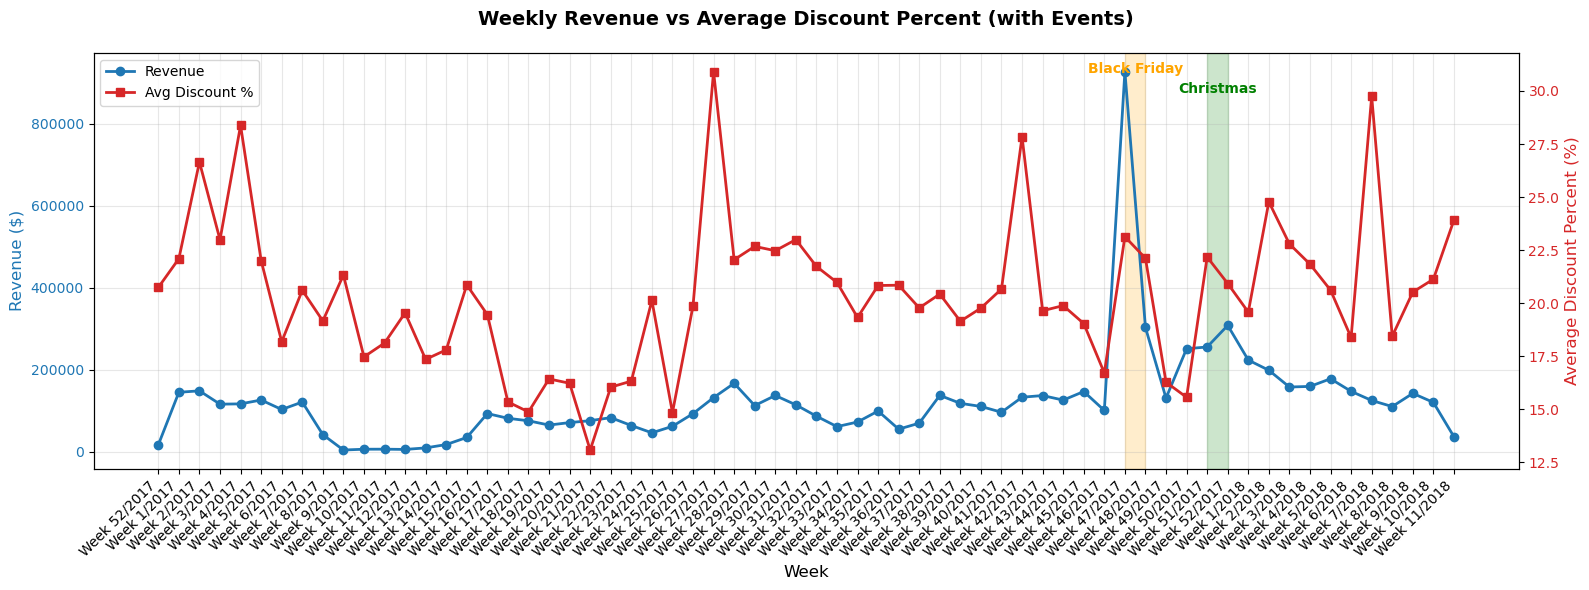

Weekly Revenue and Discount Summary:
  week_label   revenue  avg_discount_prc
Week 52/2017  16701.72         20.735937
 Week 1/2017 144924.33         22.095119
 Week 2/2017 148462.70         26.652789
 Week 3/2017 115935.15         22.984979
 Week 4/2017 116649.77         28.377475
 Week 5/2017 126083.60         22.005922
 Week 6/2017 102935.82         18.177977
 Week 7/2017 121101.70         20.601797
 Week 8/2017  41569.07         19.158359
 Week 9/2017   4048.79         21.322500
Week 10/2017   5993.55         17.463636
Week 11/2017   6103.51         18.116216
Week 12/2017   5502.67         19.538028
Week 13/2017   9203.95         17.346875
Week 14/2017  17380.02         17.794215
Week 15/2017  34680.74         20.857057
Week 16/2017  93025.62         19.453019
Week 17/2017  81481.17         15.339863
Week 18/2017  75365.44         14.868605
Week 19/2017  64909.41         16.424213
Week 20/2017  70998.02         16.218932
Week 21/2017  75631.00         13.072236
Week 22/2017  83067.

In [75]:
# Revenue and Discount Percent distribution over weeks
# Extract week from date column
orderlines_df['week'] = orderlines_df['date'].dt.to_period('W')

# Group by week and calculate metrics
weekly_stats = orderlines_df.groupby('week').agg(
    revenue=('orderline_sum', 'sum'),
    avg_discount_prc=('discount_prc', 'mean')
).reset_index()

# Format week labels as "Week X, Year"
weekly_stats['week_label'] = weekly_stats['week'].apply(lambda x: f"Week {x.week}/{x.year}")

# Find Black Friday and Christmas events in the data
from datetime import datetime
min_date = orderlines_df['date'].min()
max_date = orderlines_df['date'].max()

# Identify Black Friday dates (day after Thanksgiving - 4th Thursday of November)
# For simplicity, Black Friday is typically Nov 24-30
black_friday_dates = []
christmas_dates = []

for year in range(min_date.year, max_date.year + 1):
    # Black Friday - 4th Friday of November (approximately Nov 24-30)
    # Find the day after 4th Thursday of November
    from dateutil.relativedelta import relativedelta
    nov_first = pd.Timestamp(year=year, month=11, day=1)
    # Find 4th Thursday
    first_thursday = nov_first + pd.Timedelta(days=(3 - nov_first.weekday()))
    black_friday = first_thursday + pd.Timedelta(days=28)  # 4th Thursday + 1 day
    
    if min_date <= black_friday <= max_date:
        black_friday_dates.append(black_friday)
    
    # Christmas
    christmas = pd.Timestamp(year=year, month=12, day=25)
    if min_date <= christmas <= max_date:
        christmas_dates.append(christmas)

# Map dates to week indices
def get_week_index(date, weekly_stats_df):
    week_period = pd.Period(date, freq='W')
    matching_indices = weekly_stats_df[weekly_stats_df['week'] == week_period].index
    return matching_indices[0] if len(matching_indices) > 0 else None

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot revenue on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Week', fontsize=12)
ax1.set_ylabel('Revenue ($)', color=color, fontsize=12)
line1 = ax1.plot(range(len(weekly_stats)), weekly_stats['revenue'], color=color, marker='o', linewidth=2, label='Revenue')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create secondary y-axis for discount percent
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Discount Percent (%)', color=color, fontsize=12)
line2 = ax2.plot(range(len(weekly_stats)), weekly_stats['avg_discount_prc'], color=color, marker='s', linewidth=2, label='Avg Discount %')
ax2.tick_params(axis='y', labelcolor=color)

# Add event areas for Black Friday and Christmas (covering the week before)
for bf_date in black_friday_dates:
    idx = get_week_index(bf_date, weekly_stats)
    if idx is not None:
        ax1.axvspan(idx - 1, idx, alpha=0.2, color='orange')
        ax1.text(idx - 0.5, ax1.get_ylim()[1] * 0.95, 'Black Friday', ha='center', color='orange', fontweight='bold', fontsize=10)

for xmas_date in christmas_dates:
    idx = get_week_index(xmas_date, weekly_stats)
    if idx is not None:
        ax1.axvspan(idx - 1, idx, alpha=0.2, color='green')
        ax1.text(idx - 0.5, ax1.get_ylim()[1] * 0.90, 'Christmas', ha='center', color='green', fontweight='bold', fontsize=10)

# Add title and legend
plt.title('Weekly Revenue vs Average Discount Percent (with Events)', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(range(len(weekly_stats)))
ax1.set_xticklabels(weekly_stats['week_label'], rotation=45, ha='right')

# Combine legends from both axes
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Weekly Revenue and Discount Summary:")
print(weekly_stats[['week_label', 'revenue', 'avg_discount_prc']].to_string(index=False))

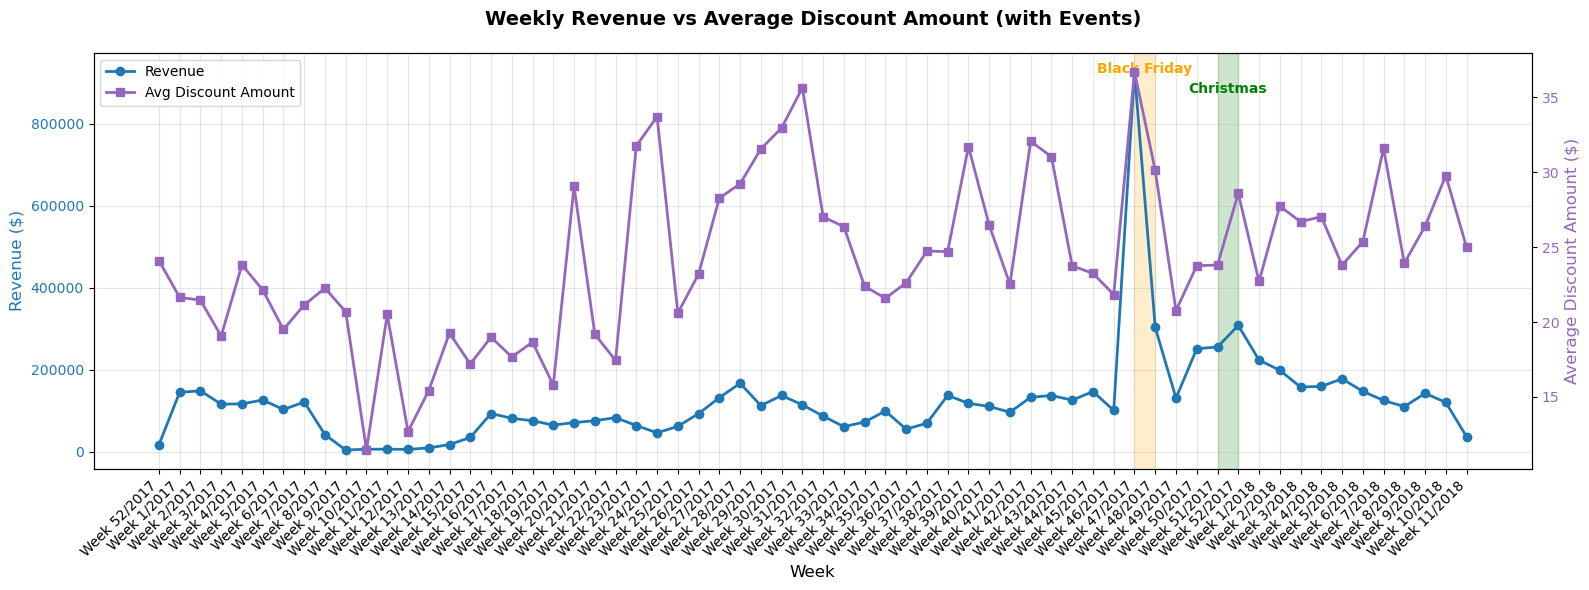

Weekly Revenue and Discount Amount Summary:
  week_label   revenue  avg_discount_amt
Week 52/2017  16701.72         24.111094
 Week 1/2017 144924.33         21.651513
 Week 2/2017 148462.70         21.465480
 Week 3/2017 115935.15         19.067468
 Week 4/2017 116649.77         23.829158
 Week 5/2017 126083.60         22.146291
 Week 6/2017 102935.82         19.510256
 Week 7/2017 121101.70         21.147072
 Week 8/2017  41569.07         22.269757
 Week 9/2017   4048.79         20.689250
Week 10/2017   5993.55         11.457955
Week 11/2017   6103.51         20.512973
Week 12/2017   5502.67         12.685915
Week 13/2017   9203.95         15.430781
Week 14/2017  17380.02         19.268512
Week 15/2017  34680.74         17.200541
Week 16/2017  93025.62         18.991051
Week 17/2017  81481.17         17.676907
Week 18/2017  75365.44         18.663391
Week 19/2017  64909.41         15.794705
Week 20/2017  70998.02         29.071505
Week 21/2017  75631.00         19.188477
Week 22/2017 

In [76]:
# Revenue and Discount Amount distribution over weeks
# Group by week and calculate metrics with discount amount
weekly_stats_amount = orderlines_df.groupby('week').agg(
    revenue=('orderline_sum', 'sum'),
    avg_discount_amt=('discount_amt', 'mean')
).reset_index()

# Format week labels as "Week X, Year"
weekly_stats_amount['week_label'] = weekly_stats_amount['week'].apply(lambda x: f"Week {x.week}/{x.year}")

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot revenue on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Week', fontsize=12)
ax1.set_ylabel('Revenue ($)', color=color, fontsize=12)
line1 = ax1.plot(range(len(weekly_stats_amount)), weekly_stats_amount['revenue'], color=color, marker='o', linewidth=2, label='Revenue')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create secondary y-axis for discount amount
ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('Average Discount Amount ($)', color=color, fontsize=12)
line2 = ax2.plot(range(len(weekly_stats_amount)), weekly_stats_amount['avg_discount_amt'], color=color, marker='s', linewidth=2, label='Avg Discount Amount')
ax2.tick_params(axis='y', labelcolor=color)

# Add event areas for Black Friday and Christmas (covering the week before)
for bf_date in black_friday_dates:
    idx = get_week_index(bf_date, weekly_stats_amount)
    if idx is not None:
        ax1.axvspan(idx - 1, idx, alpha=0.2, color='orange')
        ax1.text(idx - 0.5, ax1.get_ylim()[1] * 0.95, 'Black Friday', ha='center', color='orange', fontweight='bold', fontsize=10)

for xmas_date in christmas_dates:
    idx = get_week_index(xmas_date, weekly_stats_amount)
    if idx is not None:
        ax1.axvspan(idx - 1, idx, alpha=0.2, color='green')
        ax1.text(idx - 0.5, ax1.get_ylim()[1] * 0.90, 'Christmas', ha='center', color='green', fontweight='bold', fontsize=10)

# Add title and legend
plt.title('Weekly Revenue vs Average Discount Amount (with Events)', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(range(len(weekly_stats_amount)))
ax1.set_xticklabels(weekly_stats_amount['week_label'], rotation=45, ha='right')

# Combine legends from both axes
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Weekly Revenue and Discount Amount Summary:")
print(weekly_stats_amount[['week_label', 'revenue', 'avg_discount_amt']].to_string(index=False))